# Wikipedia Mining

Identify 5 categories of pages on wikipedia, for each category choose 300 items.

With a python script: 

*   load the pages 
*   preprocess them
*   insert them in a dataframe (save the dataframe in a CSV file and use it later for subsequent loads)
*   Create statistics (frequency and word length, for example) on the pages and show them with different types of visualization
*   Calculate the distance between pages in the same category and between different categories
*   Classify the pages, using the categories as labels
*   Check the wikipedia categorization or any deviations with a clustering method and in this case analyze the probable causes

In [ ]:
!pip3 install mediawikiapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 5.0 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import csv
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mediawikiapi
from scipy.spatial import distance
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud
import re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk import download, word_tokenize
from pathlib import Path
import os

nltk.download('all')
en_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

### Identify 5 categories of pages on wikipedia, for each category choose 300 items

In [ ]:
mediawiki = mediawikiapi.MediaWikiAPI()
categories = {'All-female bands', 'Real Madrid CF players', 'Neurological disorders', 'Demons in film',
              'High fashion brands'}

### Preprocess pages

In [ ]:
def clean_page(content):
    page_words = deque()
    for word in content.split():
        # exclude text starting from references
        word = word.lower().strip()
        if word.startswith("References"):
            break
        elif word.isalpha() and word not in en_stopwords and len(word) > 2:
            page_words.append(word)
    return page_words

### Load the pages

In [ ]:
def validate_pages(category):
    # make csv file for each category where all the pages will be stored with corresponding words
    file_name = "_".join(category.split())
    csv_path = f'categories/{file_name}.csv'
    file_path = Path(csv_path)
    file_path.parent.mkdir(parents=True, exist_ok=True)
    final_pages = set()
    all_pages = mediawiki.category_members(title=category, cmlimit=350)
    with open(file_path, "w") as f:
        writer = csv.writer(f)
        for page_name in all_pages:
            if len(final_pages) == 300:
                break
            try:
                page = mediawiki.page(page_name)
            except:
                continue
            title = "Page: " + page_name
            writer.writerow([title])
            final_pages.add(page_name)
            writer.writerow(clean_page(page.content))
    return final_pages

In [ ]:
def get_category_words(csv_file):
    words = deque()
    with open(csv_file, "r") as f:
        csv_reader = csv.reader(f)
        for line in csv_reader:
            if any("Page: " in el for el in line):
                continue
            else:
                words.append(line)
    return words

### Insert pages in dataframe   as   

In [ ]:
wiki_path = 'wikipedia_category_pages.csv'
if wiki_path not in os.listdir('/content/drive/MyDrive/Massive data mining/Project'):
    pages = {}  # dict with category names and corresponding list of pages
    for category in categories:
        pages[category] = list(validate_pages(category))
    df = pd.DataFrame(pages)
    filepath = Path('/content/drive/MyDrive/Massive data mining/Project/' + wiki_path)
    filepath.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(filepath, index=False)
else:
    df = pd.read_csv('/content/drive/MyDrive/Massive data mining/Project/' + wiki_path)
df

,Real Madrid CF players,High fashion brands,Neurological disorders,Demons in film,All-female bands
0,Alfonso Albéniz,Anderson & Sheppard,Spastic quadriplegia,Legend of the Demon Cat,Eddie Durham's All-Star Girl Orchestra
1,"Marcos Alonso (footballer, born 1990)",Frost French,Oculogyric crisis,The Alchemist Cookbook,All Our Exes Live in Texas
2,Antonio Bonet (footballer),Alpha Industries,Ideomotor apraxia,Krampus Unleashed,Poetic Pilgrimage
3,Castaño (footballer),Marchesa (brand),Kernicterus,Annabelle (film),Maybe April
4,Armando Giralt,Aimé Leon Dore,Quadrigia,Funny Man (film),Chicks on Speed
...,...,...,...,...,...
295,Mariano García Remón,The Chelsea Cobbler,Acute motor axonal neuropathy,Polaroid (film),Honoka & Azita
296,José García Calvo,L.K.Bennett,Hereditary motor and sensory neuropathy,Demon Slayer: Kimetsu no Yaiba – The Movie: Mu...,Marine Girls
297,Adrián Martín (footballer),Oroton,Korsakoff syndrome,Fantasia (1940 film),Fitts for Fight
298,José Amavisca,André Laug,Blocq's disease,Pumpkinhead: Blood Feud,Sempre Livre


In [ ]:
csv_files = os.listdir("/content/drive/MyDrive/Massive data mining/Project/categories")
cat_words = {}
for cat_name, file_name in zip(sorted(categories), sorted(csv_files)):
    csv_path = f"/content/drive/MyDrive/Massive data mining/Project/categories/{file_name}"
    cat_words[cat_name] = list(get_category_words(csv_path))
df_words = pd.DataFrame(cat_words)
df_words

,All-female bands,Demons in film,High fashion brands,Neurological disorders,Real Madrid CF players
0,"[band, musical, group, popular, music, exclusi...","[stylized, child, known, american, horror, fil...","[aadnevik, luxury, clothing, brand, provides, ...","[neurological, disorder, disorder, nervous, bi...","[real, madrid, club, fútbol, professional, ass..."
1,"[alphabetized, list, notable, list, band, over...","[adventures, mark, twain, united, kingdom, com...","[reem, acra, ريم, fashion, designer, born, kno...","[list, major, frequently, observed, neurologic...","[antonio, adán, garrido, born, may, spanish, p..."
2,"[alternative, rock, band, comprising, sisters,...","[alchemist, cookbook, horror, film, directed, ...","[agnès, agnès, andrée, marguerite, french, fas...","[also, referred, neurological, disorder, patie...","[sheyi, emmanuel, adebayor, born, february, to..."
3,"[stylized, american, funk, rock, band, backing...","[birthday, australian, horror, written, direct...","[aimé, leon, dore, fashion, lifestyle, brand, ...","[acquired, myopathy, neurological, disorder, p...","[david, aganzo, méndez, january, spanish, form..."
4,"[century, girls, teenage, band, founded, west,...","[eve, american, horror, anthology, film, direc...","[kriz, may, refer, places, jurisdictions, oasi...","[acute, motor, axonal, neuropathy, variant, ch...","[juan, bautista, agüero, sánchez, june, decemb..."
...,...,...,...,...,...
295,"[english, indie, pop, supergroup, formed, comp...","[separation, american, supernatural, horror, f...","[christian, roth, designer, luxury, early, lif...","[tarlov, type, innervated, meningeal, sacs, fr...","[andrés, mendieta, february, spanish, former, ..."
296,"[skulker, aria, rock, band, sydney, formed, tw...","[seventh, day, american, horror, film, written...","[row, luxury, fashion, label, established, ash...","[tick, paralysis, disease, caused, infectious,...","[ramón, mendizábal, amezaga, november, februar..."
297,"[solid, harmonie, solid, also, known, pop, gir...","[seventh, moon, american, horror, film, writte...","[rubin, chapelle, new, fashion, company, found...","[timothy, syndrome, rare, disorder, characteri...","[ferland, sinna, mendy, june, french, professi..."
298,"[girls, album, english, rock, band, rolling, r...","[sex, zen, carnal, prayer, mat, jade, maiden, ...","[rubinacci, italian, luxury, clothing, company...","[syndrome, rare, disorder, characterized, seve...","[adolphe, mengotti, november, spain, swiss, fo..."


### Create statistics (frequency and word length, for example) on the pages and show them with different types of visualization

In [ ]:
# Create new dataframe for word frequency

freq_df = pd.DataFrame(columns=categories)
for cat in categories:
  freq_df[cat] = df_words[cat].apply(lambda x: len(x))
freq_df

,Real Madrid CF players,Demons in film,High fashion brands,All-female bands,Neurological disorders
0,272,49,101,1206,760
1,395,538,413,2152,896
2,1779,760,362,172,611
3,189,376,246,44,908
4,46,746,33,97,247
...,...,...,...,...,...
295,20,289,273,281,1238
296,43,201,324,198,523
297,173,419,122,317,364
298,25,147,92,1887,216


In [ ]:
# Create new dataframe for word len and normalize values

def get_cat_word_len(words):
  sum = 0
  for word in words:
    sum += len(word)
  return sum 

word_len_df = pd.DataFrame(columns=categories)
for cat in categories:
  word_len_df[cat] = df_words[cat].apply(lambda x: round(get_cat_word_len(x)/len(x), 1))
word_len_df

,Real Madrid CF players,Demons in film,High fashion brands,All-female bands,Neurological disorders
0,6.2,6.0,6.7,6.0,7.6
1,6.1,5.8,6.2,5.7,8.2
2,6.1,6.4,6.2,6.1,7.0
3,6.2,6.2,6.1,6.7,7.3
4,6.2,6.1,6.8,6.1,7.5
...,...,...,...,...,...
295,7.2,6.3,6.5,5.9,7.2
296,6.7,6.2,6.3,6.3,6.7
297,6.0,5.8,6.5,6.3,7.0
298,6.8,5.3,7.0,6.2,7.2


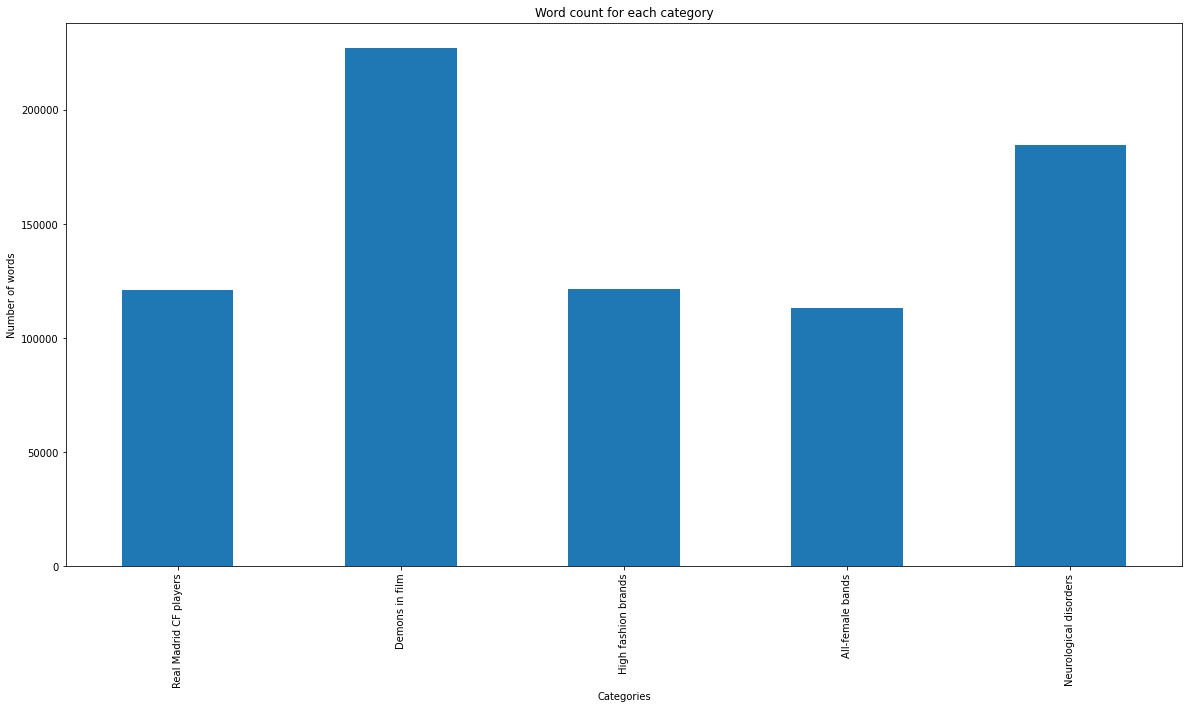

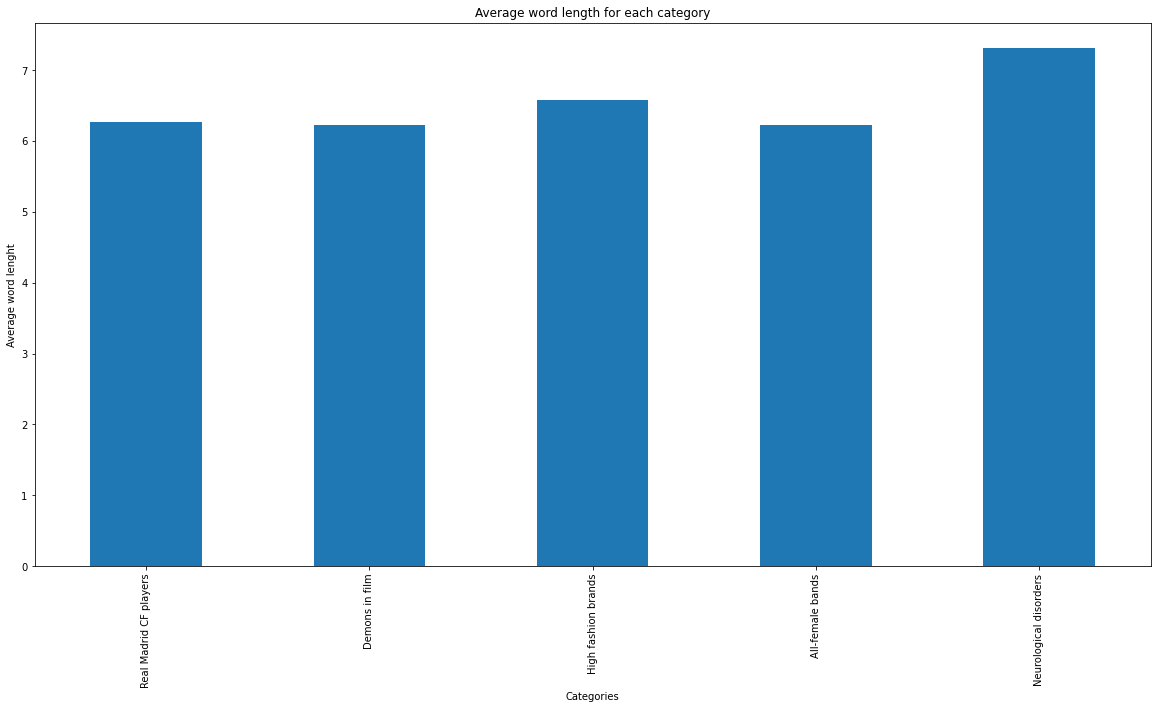

Five numbers for frequency box plot

Category: Real Madrid CF players
Min: 5
Q1: 96.00
Median: 178.0
Q3: 402.00
Max: 7105
---------------
Category: Demons in film
Min: 18
Q1: 248.75
Median: 506.0
Q3: 823.25
Max: 10004
---------------
Category: High fashion brands
Min: 12
Q1: 127.50
Median: 240.0
Q3: 433.25
Max: 3922
---------------
Category: All-female bands
Min: 23
Q1: 121.75
Median: 201.5
Q3: 401.50
Max: 5208
---------------
Category: Neurological disorders
Min: 13
Q1: 191.25
Median: 437.0
Q3: 836.50
Max: 4183
---------------

Five numbers for word length box plot

Category: Real Madrid CF players
Min: 5
Q1: 6.10
Median: 6.2
Q3: 6.40
Max: 7
---------------
Category: Demons in film
Min: 5
Q1: 6.10
Median: 6.2
Q3: 6.40
Max: 7
---------------
Category: High fashion brands
Min: 5
Q1: 6.40
Median: 6.6
Q3: 6.70
Max: 8
---------------
Category: All-female bands
Min: 5
Q1: 6.00
Median: 6.2
Q3: 6.40
Max: 7
---------------
Category: Neurological disorders
Min: 6
Q1: 7.10
Median: 7.3
Q3: 7.50
M

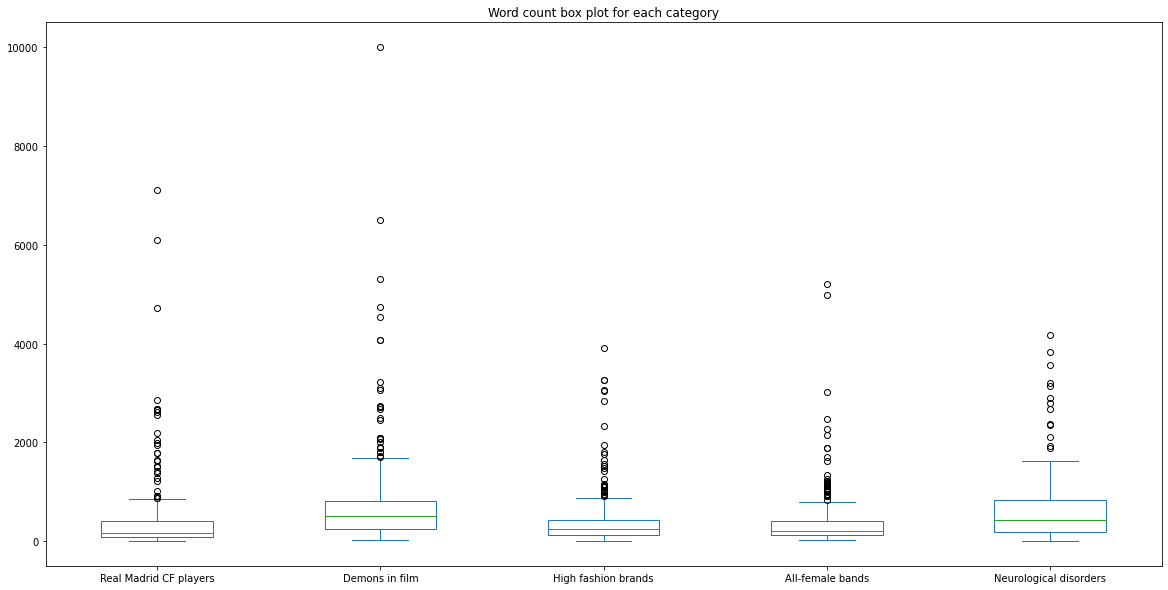

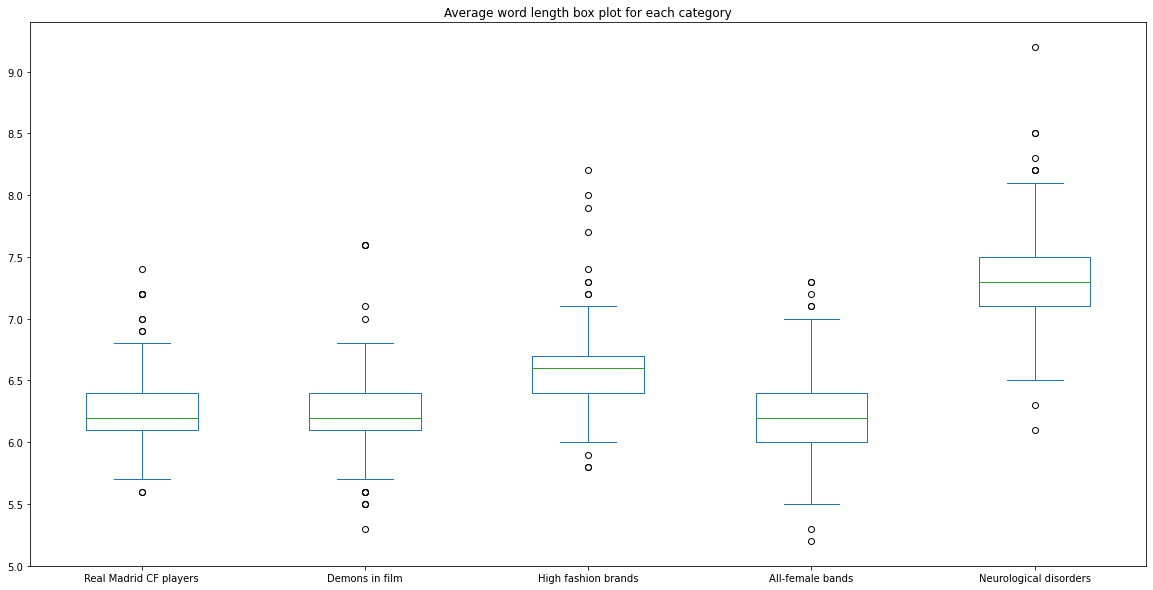

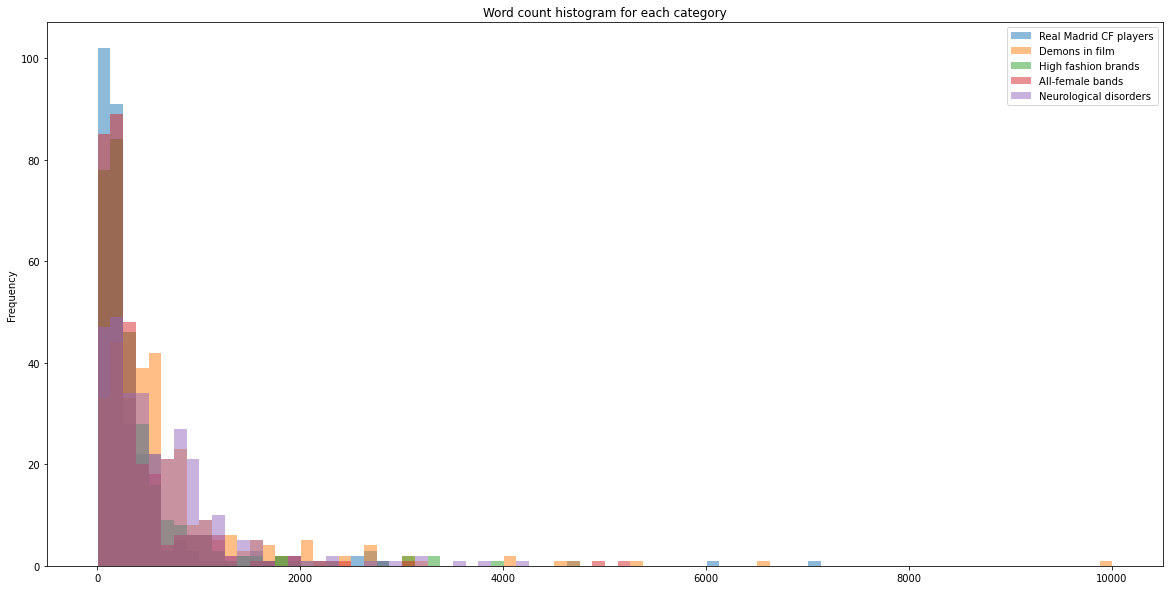

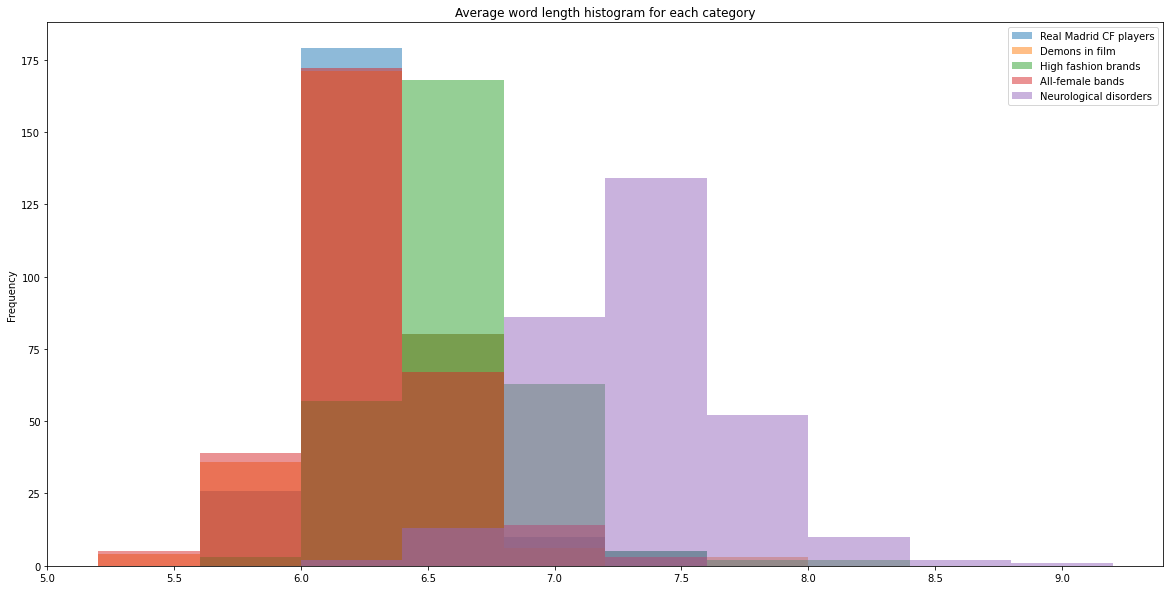

In [ ]:
# Plot word count bar chart
plt.figure(figsize=(20, 10))
freq_df.sum().plot.bar()
plt.xlabel("Categories")
plt.ylabel("Number of words")
plt.title('Word count for each category')
plt.show()

# Plot word length bar chart
plt.figure(figsize=(20, 10))
word_len_df.mean().plot.bar()
plt.xlabel("Categories")
plt.ylabel("Average word lenght")
plt.title('Average word length for each category')
plt.show()

# Plot word count box plot
freq_df.plot.box(figsize=(20, 10), title='Word count box plot for each category')

print(f"Five numbers for frequency box plot\n")
for category in categories:
  quartiles = np.percentile(freq_df[category], [25, 50, 75])
  # five numbers
  print(f"Category: {category}")
  print('Min: %d' % freq_df[category].min())
  print('Q1: %.2f' % quartiles[0]) 
  print('Median: %.1f' % quartiles[1])  
  print('Q3: %.2f' % quartiles[2])
  print('Max: %d' % freq_df[category].max())
  print("---------------")

print()

# Plot word length box plot
word_len_df.plot.box(figsize=(20, 10), title='Average word length box plot for each category')

print("Five numbers for word length box plot\n")
for category in categories:
  quartiles = np.percentile(word_len_df[category], [25, 50, 75])
  # five numbers
  print(f"Category: {category}")
  print('Min: %d' % word_len_df[category].min())
  print('Q1: %.2f' % quartiles[0]) 
  print('Median: %.1f' % quartiles[1])  
  print('Q3: %.2f' % quartiles[2])
  print('Max: %d' % word_len_df[category].max())
  print("---------------")

# Plot word count histogram
freq_df.plot.hist(figsize=(20, 10), title='Word count histogram for each category', bins=80, alpha=0.5)

# Plot word lenght histogram
word_len_df.plot.hist(figsize=(20, 10), title='Average word length histogram for each category', bins=10, alpha=0.5)

### Calculate the distance between pages in the same category and between different categories

In [ ]:
vectorizer = CountVectorizer(analyzer='word', stop_words='english')
tfidf = TfidfTransformer()

rows = []

# Distances between the same category
for category in categories:
  cat_words = df_words[category]
  transformed_words = []
  for el in cat_words:
    rows.append([category, " ".join(el).strip()])
    transformed_words.append(" ".join(el).strip())
  X = vectorizer.fit_transform(transformed_words)
  X_t = tfidf.fit_transform(X)
  X_t = X_t.toarray()
  dm = distance.cdist(X_t, X_t, "cosine")
  print(f"Similiraty between items in category: {category}")
  print("min: %.2f" % dm.min())
  print("mean: %.2f" % dm.mean())
  print("median: %.2f" % np.median(dm))
  print("max: %.2f" % dm.max())
  print("-------------------")

text_df = pd.DataFrame(data=rows, columns=["category", "text"])
text_df

Similiraty between items in category: Real Madrid CF players
min: 0.00
mean: 0.95
median: 0.96
max: 1.00
-------------------
Similiraty between items in category: Demons in film
min: 0.00
mean: 0.96
median: 0.97
max: 1.00
-------------------
Similiraty between items in category: High fashion brands
min: 0.00
mean: 0.98
median: 0.98
max: 1.00
-------------------
Similiraty between items in category: All-female bands
min: 0.00
mean: 0.96
median: 0.97
max: 1.00
-------------------
Similiraty between items in category: Neurological disorders
min: 0.00
mean: 0.96
median: 0.97
max: 1.00
-------------------


,category,text
0,Real Madrid CF players,real madrid club fútbol professional associati...
1,Real Madrid CF players,antonio adán garrido born may spanish professi...
2,Real Madrid CF players,sheyi emmanuel adebayor born february togolese...
3,Real Madrid CF players,david aganzo méndez january spanish former foo...
4,Real Madrid CF players,juan bautista agüero sánchez june december par...
...,...,...
1495,Neurological disorders,tarlov type innervated meningeal sacs frequent...
1496,Neurological disorders,tick paralysis disease caused infectious illne...
1497,Neurological disorders,timothy syndrome rare disorder characterized p...
1498,Neurological disorders,syndrome rare disorder characterized severe un...


In [ ]:
X = vectorizer.fit_transform(text_df["text"])
X_t = tfidf.fit_transform(X)
X_t = X_t.toarray()
visited = set()

for cat1 in categories:
  for cat2 in categories:
    if cat1 != cat2 and (cat2, cat1) not in visited:
      visited.add((cat1,cat2))
      X_t1 = X_t[text_df['category'] == cat1]
      X_t2 = X_t[text_df['category'] == cat2]
      dm = distance.cdist(X_t1, X_t2, "cosine")
      print(f"Similiraty between items in categories: {cat1}-{cat2}")
      print("min: %.2f" % dm.min())
      print("mean: %.2f" % dm.mean())
      print("median: %.2f" % np.median(dm))
      print("max: %.2f" % dm.max())
      print("-------------------")

Similiraty between items in categories: Real Madrid CF players-Demons in film
min: 0.75
mean: 0.99
median: 0.99
max: 1.00
-------------------
Similiraty between items in categories: Real Madrid CF players-High fashion brands
min: 0.56
mean: 0.99
median: 0.99
max: 1.00
-------------------
Similiraty between items in categories: Real Madrid CF players-All-female bands
min: 0.81
mean: 0.99
median: 0.99
max: 1.00
-------------------
Similiraty between items in categories: Real Madrid CF players-Neurological disorders
min: 0.90
mean: 1.00
median: 1.00
max: 1.00
-------------------
Similiraty between items in categories: Demons in film-High fashion brands
min: 0.64
mean: 0.99
median: 0.99
max: 1.00
-------------------
Similiraty between items in categories: Demons in film-All-female bands
min: 0.74
mean: 0.99
median: 0.99
max: 1.00
-------------------
Similiraty between items in categories: Demons in film-Neurological disorders
min: 0.76
mean: 0.99
median: 0.99
max: 1.00
-------------------


### Classify the pages, using the categories as labels

In [ ]:
lemmatizer = WordNetLemmatizer()

text = text_df["text"]
corpus = []

for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

text_df['text'] = corpus

text_df

,category,text
0,Real Madrid CF players,real madrid club f tbol professional associati...
1,Real Madrid CF players,antonio ad n garrido born may spanish professi...
2,Real Madrid CF players,sheyi emmanuel adebayor born february togolese...
3,Real Madrid CF players,david aganzo ndez january spanish former footb...
4,Real Madrid CF players,juan bautista ag ero nchez june december parag...
...,...,...
1495,Neurological disorders,tarlov type innervated meningeal sac frequentl...
1496,Neurological disorders,tick paralysis disease caused infectious illne...
1497,Neurological disorders,timothy syndrome rare disorder characterized p...
1498,Neurological disorders,syndrome rare disorder characterized severe un...


In [ ]:
y = text_df['category']
x = text_df['text']

# splitting feature matrix X and y into stratified training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(x_train)
X_test_cv = cv.transform(x_test)

In [ ]:
# Naive Bayes classifier

naive_bayes_clf = MultinomialNB()
naive_bayes_clf.fit(X_train_cv, y_train)

y_pred = naive_bayes_clf.predict(X_test_cv)

print("Naive Bayes classifier report:")
print(metrics.classification_report(y_test, y_pred))

Naive Bayes classifier report:
                        precision    recall  f1-score   support

      All-female bands       0.99      0.91      0.95        90
        Demons in film       0.94      0.99      0.96        90
   High fashion brands       0.93      0.97      0.95        90
Neurological disorders       0.98      0.98      0.98        90
Real Madrid CF players       0.99      0.97      0.98        90

              accuracy                           0.96       450
             macro avg       0.96      0.96      0.96       450
          weighted avg       0.96      0.96      0.96       450



In [ ]:
# Random forest classifier 

random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train_cv, y_train)
y_pred = random_forest_clf.predict(X_test_cv)

print("Random Forest classifier report:")
print(metrics.classification_report(y_test, y_pred))

Random Forest classifier report:
                        precision    recall  f1-score   support

      All-female bands       0.99      0.93      0.96        90
        Demons in film       0.98      0.99      0.98        90
   High fashion brands       0.92      0.94      0.93        90
Neurological disorders       0.95      0.99      0.97        90
Real Madrid CF players       0.99      0.97      0.98        90

              accuracy                           0.96       450
             macro avg       0.97      0.96      0.96       450
          weighted avg       0.97      0.96      0.96       450



In [ ]:
# KNN classifier

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train_cv, y_train)
y_pred = knn_clf.predict(X_test_cv)

print("KNN classifier report:")
print(metrics.classification_report(y_test, y_pred))

KNN classifier report:
                        precision    recall  f1-score   support

      All-female bands       0.97      0.81      0.88        90
        Demons in film       0.99      0.87      0.92        90
   High fashion brands       0.80      0.74      0.77        90
Neurological disorders       0.94      0.91      0.93        90
Real Madrid CF players       0.70      0.98      0.82        90

              accuracy                           0.86       450
             macro avg       0.88      0.86      0.86       450
          weighted avg       0.88      0.86      0.86       450



### Check the wikipedia categorization or any deviations with a clustering method and in this case analyze the probable causes

In [ ]:
kmeans = KMeans(n_clusters=5).fit(X_t)

# Get the labels using KMeans
pred_labels = kmeans.labels_

In [ ]:
# Compute DBI score
dbi = metrics.davies_bouldin_score(X_t, pred_labels)

# Compute Silhoutte Score
ss = metrics.silhouette_score(X_t, pred_labels , metric='euclidean')

# Print the DBI and Silhoutte Scores
print("DBI Score: ", dbi, "\nSilhoutte Score: ", ss)

DBI Score:  7.239152527530678 
Silhoutte Score:  0.02185590059381723


In [ ]:
def word_cloud(text, wc_title):

    # Create WordCloud 
    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = en_stopwords, 
                           min_font_size = 14).generate(text) 

    plt.figure(figsize = (20, 10))
    plt.title(wc_title)
    plt.imshow(word_cloud) 
    plt.axis("off")  
    plt.show()

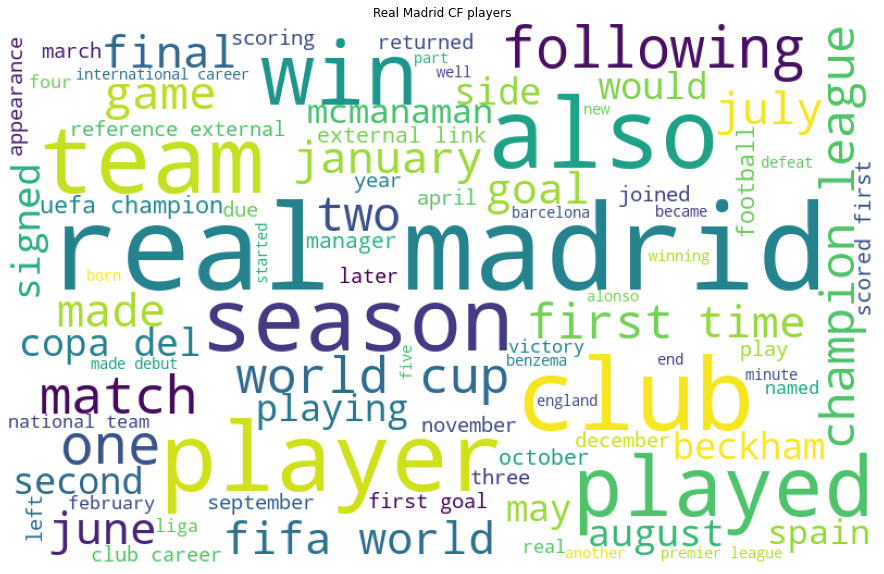

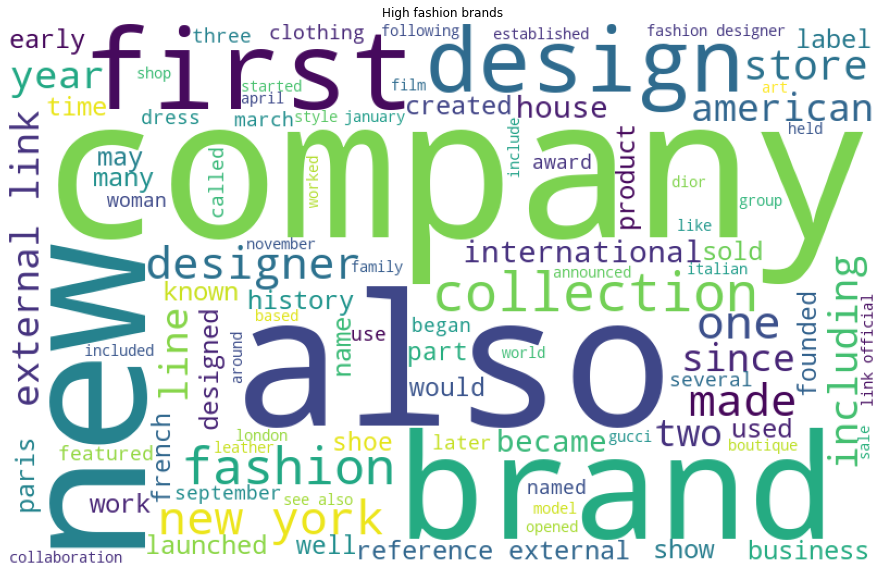

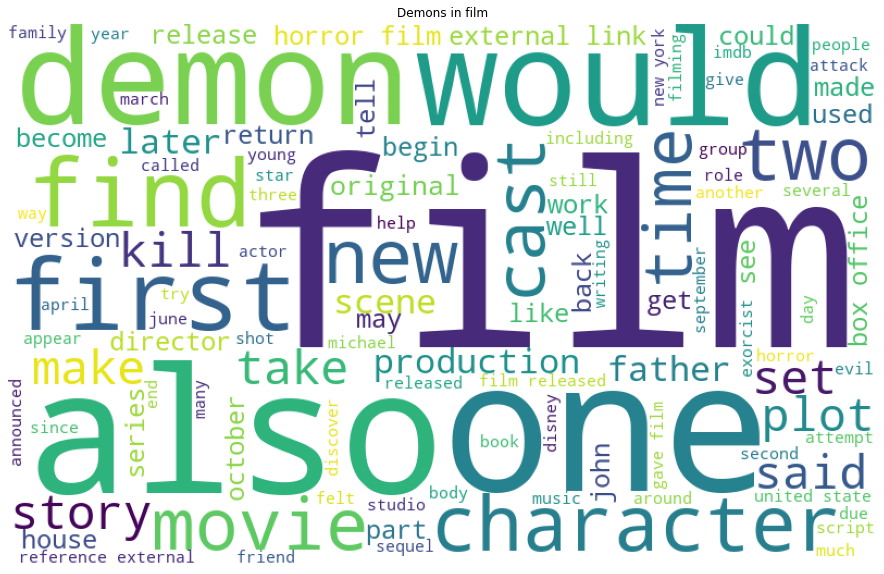

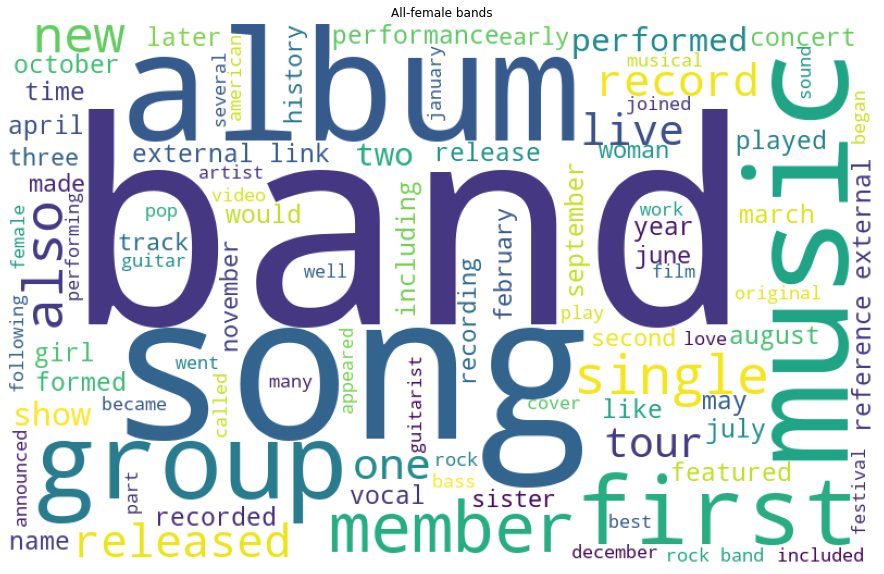

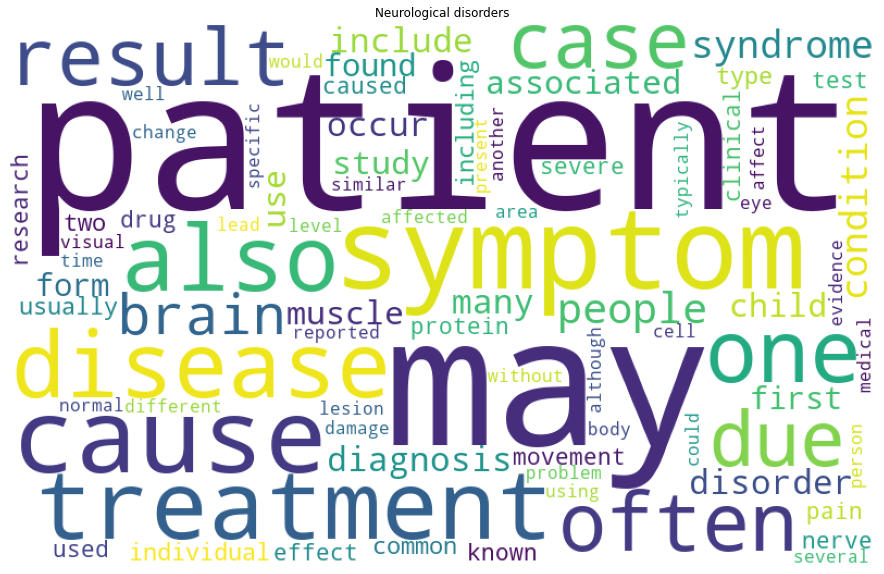

In [ ]:
df_km = text_df.assign(labels=pred_labels)

for i in df_km.labels.unique():
    new_df = df_km[df_km["labels"] == i]
    text="".join(new_df["text"].tolist())
    title = new_df["category"].astype(str).value_counts().idxmax()
    word_cloud(text, title)